## Plots - ZTF
In this notebook, we take outputs from our run on two weeks worth of ZTF alerts and make a series of plots for the 
THOR paper. 

[Survey Footprint [Fig 9]](#Survey-Footprint)   
[Completeness [Fig 11]](#Completeness)  

This notebook creates Figures 7 and 8.

Data and results files for this notebook may be downloaded [here](https://dirac.astro.washington.edu/~moeyensj/projects/thor/paper1/).

In [1]:
import glob
import os
import copy
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import seaborn as sns
sns.set(font_scale=1.0, context="paper", style="ticks")
sns.set_palette("viridis")

from astropy.time import Time

from scipy.stats import binned_statistic_2d

%matplotlib inline

import plotly
plotly.offline.init_notebook_mode(connected=True)

In [2]:
import thor

from thor import __version__
print("THOR version: {}".format(__version__))

THOR version: 1.1.dev199+g1c54766.d20210401


In [3]:
DPI = 300
SAVE_DIR = "plots/"
FORMAT = "png"

SAVE_FIGS = True

In [4]:
from thor.orbits import Orbits
from thor.utils import unpackMPCDesignation

DATA_DIR = "/mnt/data/projects/thor/thor_data/ztf/"
preprocessed_observations = pd.read_csv(
    os.path.join(DATA_DIR, "preprocessed_observations.csv"),
    index_col=False,
    dtype={"obs_id" : str}
)
preprocessed_associations = pd.read_csv(
    os.path.join(DATA_DIR, "preprocessed_associations.csv"),
    index_col=False,
    dtype={"obs_id" : str}
)
# Read original observations 
observations = pd.read_csv(
    os.path.join(DATA_DIR, "ztf_observations_610_624.csv"),
    index_col=False,
    sep=" ",
    dtype={"candid" : str},
    low_memory=False
)
RUN_DIR = "/mnt/data/projects/thor/thor_results/ztf/v1.1/run4"

test_orbits = Orbits.from_csv("/mnt/data/projects/thor/thor_results/ztf/v1.1/test_orbits.csv")
test_orbits = test_orbits.to_df(include_units=False)
test_orbits.loc[~test_orbits["designation"].str.isnumeric(), "designation"] = test_orbits[~test_orbits["designation"].str.isnumeric()]["designation"].apply(unpackMPCDesignation)

In [5]:
from thor.utils import unpackMPCDesignation

# Read orbits file (MPCORB in OORB format from 2018)
known_orbits = pd.read_csv(
    "/mnt/data/projects/thor/thor_data/ztf/MPCORB_20181106_ZTF_keplerian.orb", 
    delim_whitespace=True, 
    skiprows=4,
    names=["designation", "a_au", "e", "i_deg", "ascNode_deg", "argPeri_deg", "meanAnom_deg", "epoch_mjd_tt", "H", "G"],
    low_memory=False
)
known_orbits.loc[:, "designation"] = known_orbits["designation"].apply(unpackMPCDesignation)
known_orbits = known_orbits[known_orbits["designation"].isin(preprocessed_associations["obj_id"].unique())]

In [6]:
known_orbits

,designation,a_au,e,i_deg,ascNode_deg,argPeri_deg,meanAnom_deg,epoch_mjd_tt,H,G
24,25,2.400161,0.254614,21.60484,214.13060,90.26320,110.352151,58364.131287,7.83,0.15
34,35,2.994072,0.225588,7.93272,353.73890,213.39677,170.377664,58364.131287,8.50,0.15
47,48,3.110088,0.072444,6.54742,183.55392,253.05401,26.989431,58364.131287,6.90,0.15
57,58,2.700076,0.042782,5.06541,161.10757,30.80170,246.067061,58364.131287,8.86,0.15
64,65,3.425953,0.111943,3.56353,155.61620,102.63085,224.346157,58364.131287,6.62,0.01
...,...,...,...,...,...,...,...,...,...,...
788558,2018 RK1,2.329186,0.312291,27.48645,342.00803,353.21310,11.664594,58364.131287,18.80,0.15
788569,2018 RM3,2.630455,0.484081,11.08690,196.36231,197.33103,348.839281,58364.131287,20.50,0.15
788571,2018 RP3,2.140752,0.317913,6.65454,295.67620,347.31493,38.615980,58364.131287,18.70,0.15
788573,2018 RF4,2.701907,0.334816,13.50859,74.56787,329.56481,341.164499,58364.131287,17.40,0.15


In [7]:
sma_bins = [0, 1.7, 2.06, 2.5, 2.82, 2.95, 3.27, 5.0, 50, 1000.0]
classes = {}
for i, (bin_start, bin_end) in enumerate(zip(sma_bins[:-1], sma_bins[1:])):
    bin_mask = (known_orbits["a_au"] >= bin_start) & (known_orbits["a_au"] < bin_end)
    classes["{}<=a<{}".format(bin_start, bin_end)] = known_orbits[bin_mask]["designation"].unique()

# Observations unattributed by ZTF
classes["Unknown"] = preprocessed_associations[preprocessed_associations["obj_id"].str.contains("^u[0-9]{8}$", regex=True)]["obj_id"].unique()

# Observations attributed by ZTF that could not be matched the known catalog (probably designation changes or comets)
unclassified_mask = ~preprocessed_associations["obj_id"].isin(known_orbits["designation"].unique()) & (~preprocessed_associations["obj_id"].str.contains("^u[0-9]{8}$", regex=True))
classes["Unmatched"] = preprocessed_associations[unclassified_mask]["obj_id"].unique()

In [8]:
simulated_ephemeris = pd.read_csv(
    "/mnt/data/projects/thor/thor_data/ztf/MPCORB_20181106_ZTF.eph",
    delim_whitespace=True,
    header=0,
    low_memory=False
)
simulated_ephemeris.rename(
    columns={
        "#Designation" : "designation",
        "RA" : "RA_deg",
        "Dec" : "Dec_deg",
        "MJD_UTC/UT1" : "exp_mjd",
        "r" : "r_au",
        "HEclObj_X" : "HEclObj_X_au",
        "HEclObj_Y" : "HEclObj_Y_au",
        "HEclObj_Z" : "HEclObj_Z_au",
        "HEclObj_dX/dt" : "HEclObj_dX/dt_au_p_day",
        "HEclObj_dY/dt" : "HEclObj_dY/dt_au_p_day",
        "HEclObj_dZ/dt" : "HEclObj_dZ/dt_au_p_day",
    },
    inplace=True
)

In [9]:
ANALYSIS_DIR = os.path.join(RUN_DIR, "analysis_2018")

recovered_orbits = Orbits.from_csv(
    os.path.join(RUN_DIR, "recovered_orbits.csv"),
).to_df(include_units=False)

recovered_orbit_members = pd.read_csv(
    os.path.join(RUN_DIR, "recovered_orbit_members.csv"),
    index_col=False,
    dtype={"obs_id" : str}
)
all_orbits_recovered = pd.read_csv(
    os.path.join(ANALYSIS_DIR, "all_orbits_recovered.csv"),
    index_col=False
)
all_truths_recovered = pd.read_csv(
    os.path.join(ANALYSIS_DIR, "all_truths_recovered.csv"),
    index_col=False
)
summary_recovered = pd.read_csv(
    os.path.join(ANALYSIS_DIR, "summary_recovered.csv"),
    index_col=False
)
all_linkages = pd.read_csv(
    os.path.join(ANALYSIS_DIR, "all_linkages.csv"),
    index_col=False
)
all_truths = pd.read_csv(
    os.path.join(ANALYSIS_DIR, "all_truths.csv"),
    index_col=False
)
summary = pd.read_csv(
    os.path.join(ANALYSIS_DIR, "summary.csv"),
    index_col=False
)
summary_components = pd.read_csv(
    os.path.join(ANALYSIS_DIR, "summary_components.csv"),
    index_col=False
)

### Survey Footprint 

In [10]:
size = 15
ras = np.arange(-180, 180 + size, size)
decs = np.arange(-90, 90 + size, size)

<ipython-input-11-78cd2761ed36>:28: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-11-78cd2761ed36>:69: UserWarning:

FixedFormatter should only be used together with FixedLocator



[-200. -150. -100.  -50.    0.   50.  100.  150.  200.]


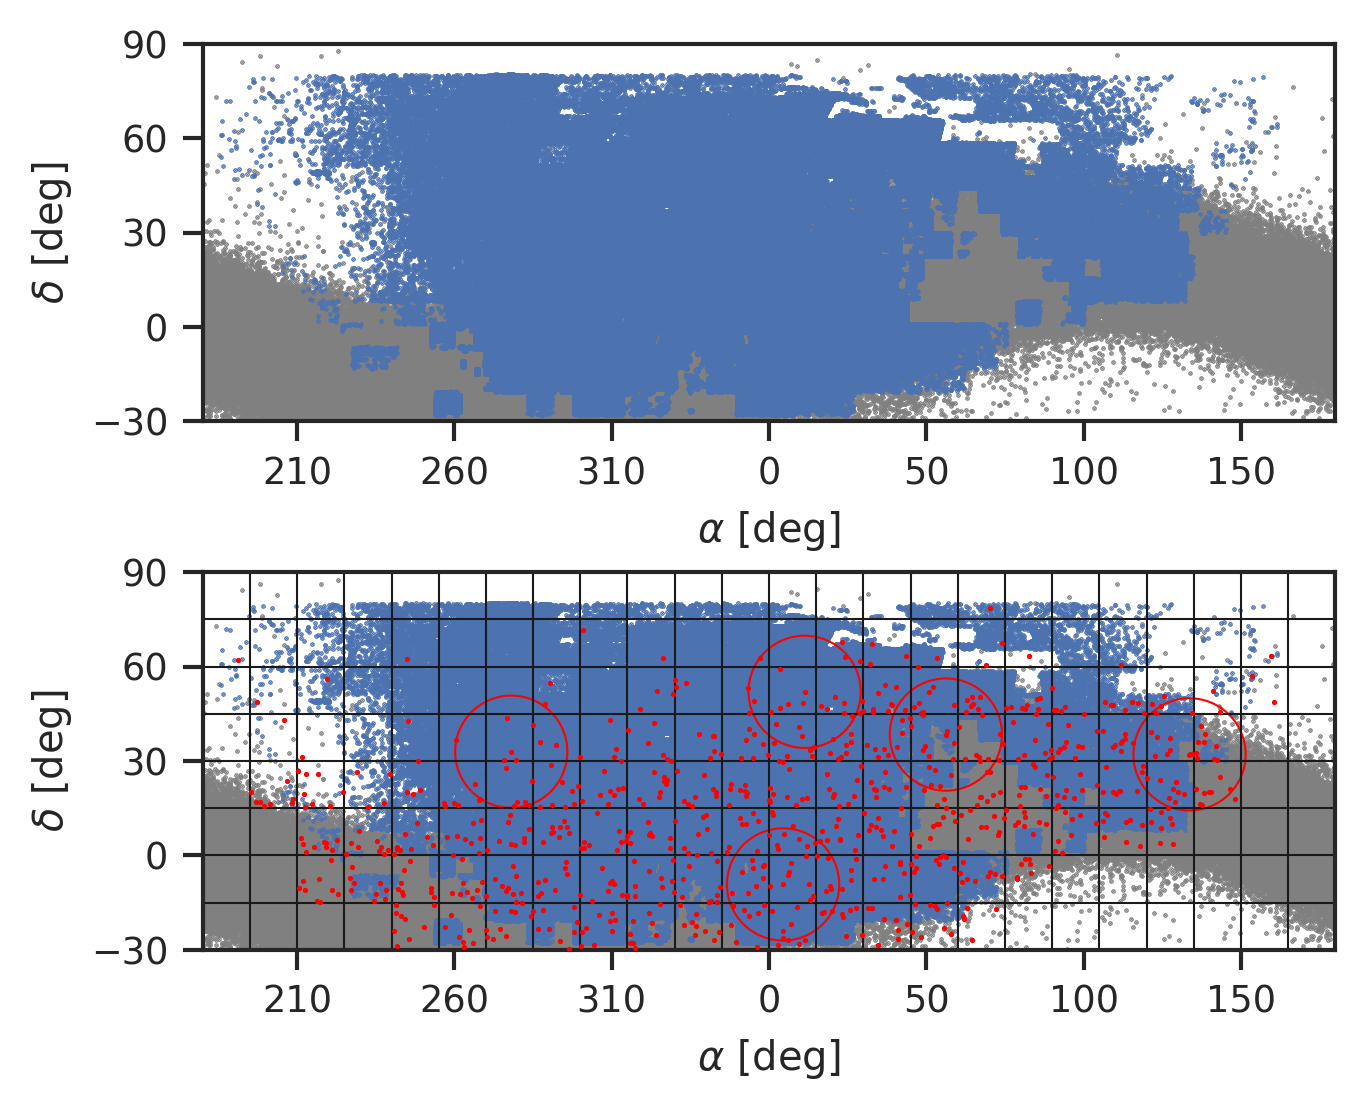

In [11]:
fig, ax = plt.subplots(2, 1, dpi=DPI, figsize=(5.5, 4))
fig.subplots_adjust(hspace=0.4)

eph_ra = simulated_ephemeris["RA_deg"].values
eph_ra = np.where(eph_ra > 180, eph_ra - 360.0, eph_ra)
obs_ra = preprocessed_observations["RA_deg"].values
obs_ra = np.where(obs_ra > 180, obs_ra - 360.0, obs_ra)

ax[0].scatter(
    eph_ra, 
    simulated_ephemeris["Dec_deg"].values,
    s=0.1,
    c="#808080"
)
ax[0].scatter(
    obs_ra,
    preprocessed_observations["Dec_deg"].values,
    s=0.1,
    c="b"
)
ax[0].set_aspect("equal")
ax[0].set_xlabel(r"$\alpha$ [$\deg$]")
ax[0].set_ylabel(r"$\delta$ [$\deg$]")
ax[0].set_ylim(-30, 90)
ax[0].set_xlim(-180, 180)
ticks = ax[0].get_xticks()
ticks[ticks < 0] += 360
ax[0].set_xticklabels([int(tick) for tick in ticks])
ax[0].set_yticks([-30, 0, 30, 60, 90])

test_orb_ra = test_orbits["RA_deg"].values
test_orb_ra = np.where(test_orb_ra > 180, test_orb_ra - 360.0, test_orb_ra)

ax[1].scatter(
    eph_ra, 
    simulated_ephemeris["Dec_deg"].values,
    s=0.1,
    c="#808080"
)
ax[1].scatter(
    obs_ra, 
    preprocessed_observations["Dec_deg"].values,
    s=0.1,
    c="b"
)
ax[1].scatter(
    test_orb_ra, 
    test_orbits["Dec_deg"].values,
    s=0.2,
    c="red",
    zorder=10
)
for ra, dec in test_orbits[test_orbits.index.isin([10, 49, 201, 401, 602])][["RA_deg", "Dec_deg"]].values:
    if ra > 180:
        ra -= 360.0
    ax[1].add_patch(patches.Circle([ra, dec], np.sqrt(1000/np.pi), fill=False, lw=0.5, color="red"))

ax[1].hlines(decs, -180, 180, lw=0.5, color="k")
ax[1].vlines(ras, -30, 90, lw=0.5, color="k")
ax[1].set_aspect("equal")
ax[1].set_xlabel(r"$\alpha$ [$\deg$]")
ax[1].set_ylabel(r"$\delta$ [$\deg$]")
ax[1].set_ylim(-30, 90)
ax[1].set_xlim(-180, 180)
#ax[1].set_xticks([-180, -120, -60, 0 , 60, 120, 180])
ticks = ax[1].get_xticks()
print(ticks)
ticks[ticks < 0] += 360
ax[1].set_xticklabels([int(tick) for tick in ticks])
ax[1].set_yticks([-30, 0, 30, 60, 90])
if SAVE_FIGS == True:
    fig.savefig(
        os.path.join(SAVE_DIR, "ztf_footprint.{}".format(FORMAT)),
        bbox_inches='tight'
    )

### Completeness

In [12]:
def plotCompleteness(
        all_truths, 
        orbits, 
        test_orbits=None, 
        test_orbit_scatter_kwargs={"s": 2, "c": "red"}
    ):
    
    findable = all_truths[all_truths["findable"] >= 1]["obj_id"].values
    found = all_truths[all_truths["found"] >= 1]["obj_id"].values
    missed = all_truths[(all_truths["found"] == 0) & (all_truths["findable"] >= 1)]["obj_id"].values

    BINS = 50
    RANGE_AI = [[0.5, 5.5], [0, 50]]
    RANGE_AE = [RANGE_AI[0], [0, 1]]
    LEVELS = [10, 100, 1000]

    # Calculate 2D binned statistics:
    # X_ai: orbital distribution in a and i
    # N_ai : number of objects discoverable in same bins as X_ai
    X_ai = binned_statistic_2d(
        orbits[orbits["designation"].isin(found)]["a_au"].values,
        orbits[orbits["designation"].isin(found)]["i_deg"].values,
        orbits[orbits["designation"].isin(found)]["e"].values,    
        statistic="count",
        range=RANGE_AI,
        bins=BINS
    )

    N_ai = binned_statistic_2d(
        orbits[orbits["designation"].isin(findable)]["a_au"].values,
        orbits[orbits["designation"].isin(findable)]["i_deg"].values,
        orbits[orbits["designation"].isin(findable)]["e"].values,    
        statistic="count",
        range=RANGE_AI,
        bins=BINS
    )
    
    stat_ai = X_ai.statistic.T / N_ai.statistic.T * 100.0
    counts_ai = N_ai.statistic.T
    stat_ai=np.ma.masked_where(stat_ai==np.NaN, stat_ai)
    
    # Calculate 2D binned statistics:
    # X_ae: orbital distribution in a and e
    # N_ae : number of objects discoverable in same bins as X_ai
    X_ae = binned_statistic_2d(
        orbits[orbits["designation"].isin(found)]["a_au"].values,
        orbits[orbits["designation"].isin(found)]["e"].values,
        orbits[orbits["designation"].isin(found)]["i_deg"].values,    
        statistic="count",
        range=RANGE_AE,
        bins=BINS
    )

    N_ae = binned_statistic_2d(
        orbits[orbits["designation"].isin(findable)]["a_au"].values,
        orbits[orbits["designation"].isin(findable)]["e"].values,
        orbits[orbits["designation"].isin(findable)]["i_deg"].values,    
        statistic="count",
        range=RANGE_AE,
        bins=BINS
    )

    stat_ae = X_ae.statistic.T / N_ae.statistic.T * 100.0
    counts_ae = N_ae.statistic.T
    stat_ae=np.ma.masked_where(stat_ae==np.NaN, stat_ae)
    
    # Make the figure
    fig, ax = plt.subplots(2, 1, dpi=DPI, figsize=(5.5, 9))
    fig.subplots_adjust(
        # the left side of the subplots of the figure
        left=0.15,  
        # the right side of the subplots of the figure
        right=1.0,
        # the bottom of the subplots of the figure
        bottom=0.2,
        # the top of the subplots of the figure
        top=0.95,
        # the amount of width reserved for space between subplots,
        # expressed as a fraction of the average axis width
        wspace=0.01,   
        # the amount of height reserved for space between subplots,
        # expressed as a fraction of the average axis height
        hspace=0.2)   
                       
    
    # Set NaN values in stat to be white 
    cmap = copy.copy(matplotlib.cm.get_cmap("viridis"))
    cmap.set_bad('w', np.NaN)
    
    # Plot a-i completeness
    cm1 = ax[0].imshow(
        stat_ai, 
        origin="lower", 
        cmap=cmap,
        interpolation='none',
        aspect="auto",
        extent=[X_ai.x_edge[0], X_ai.x_edge[-1], X_ai.y_edge[0], X_ai.y_edge[-1]]
    )

    # Add contours
    cs1 = ax[0].contour(
        counts_ai, 
        LEVELS, 
        origin="lower", 
        extent=[N_ai.x_edge[0], N_ai.x_edge[-1], N_ai.y_edge[0], N_ai.y_edge[-1]],
        colors="red",
        linewidths=1
    )
    plt.clabel(cs1, inline=1, fontsize=4, fmt="%1.0f")

    # Add labels
    ax[0].set_ylabel("Inclination ($i$) [$\deg$]")
    ax[0].set_xlabel("Semi-Major Axis ($a$) [au]")
    ax[0].set_xlim(*RANGE_AI[0])
    ax[0].set_ylim(*RANGE_AI[1])
    ax[0].set_xticks(np.arange(0.5, 6.0, 0.5))
    ax[0].set_yticks(np.arange(0.0, 55, 5))
    
    # Plot a-e completeness
    cm2 = ax[1].imshow(
        stat_ae, 
        origin="lower", 
        cmap=cmap,
        interpolation='none',
        aspect="auto",
        #norm=colors.LogNorm(),
        extent=[X_ae.x_edge[0], X_ae.x_edge[-1], X_ae.y_edge[0], X_ae.y_edge[-1]]
    )
    
    # Plot test orbits 
    if type(test_orbits) == pd.DataFrame:
        
        ax[0].scatter(
            *test_orbits[["a_au", "i_deg"]].values.T, 
            label="Test Orbits",
            zorder=10,
            **test_orbit_scatter_kwargs
        )

        ax[1].scatter(
            *test_orbits[["a_au", "e"]].values.T, 
            label="Test Orbits",
            zorder=10,
            **test_orbit_scatter_kwargs
        )

    # Add contours
    cs2 = ax[1].contour(
        counts_ae, 
        LEVELS, 
        origin="lower", 
        extent=[N_ae.x_edge[0], N_ae.x_edge[-1], N_ae.y_edge[0], N_ae.y_edge[-1]],
        colors="red",
        linewidths=1
    )
    plt.clabel(cs2, inline=1, fontsize=4, fmt="%1.0f")

    # Add labels
    ax[1].set_ylabel("Eccentricity ($e$)")
    ax[1].set_xlabel("Semi-Major Axis ($a$) [au]")
    ax[1].set_xlim(*RANGE_AE[0])
    ax[1].set_ylim(*RANGE_AE[1])
    ax[1].set_xticks(np.arange(0.5, 6.0, 0.5))
    ax[1].set_yticks(np.arange(0.0, 1.1, 0.1))
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.15, 0.1, 0.65, 0.02])
    fig.colorbar(cm2, 
                 cax=cbar_ax, 
                 label="Completeness [%]", 
                 format="%1i", 
                 orientation="horizontal")
     
    return fig, ax 

<ipython-input-12-327146b45013>:38: RuntimeWarning:

invalid value encountered in true_divide

<ipython-input-12-327146b45013>:63: RuntimeWarning:

invalid value encountered in true_divide



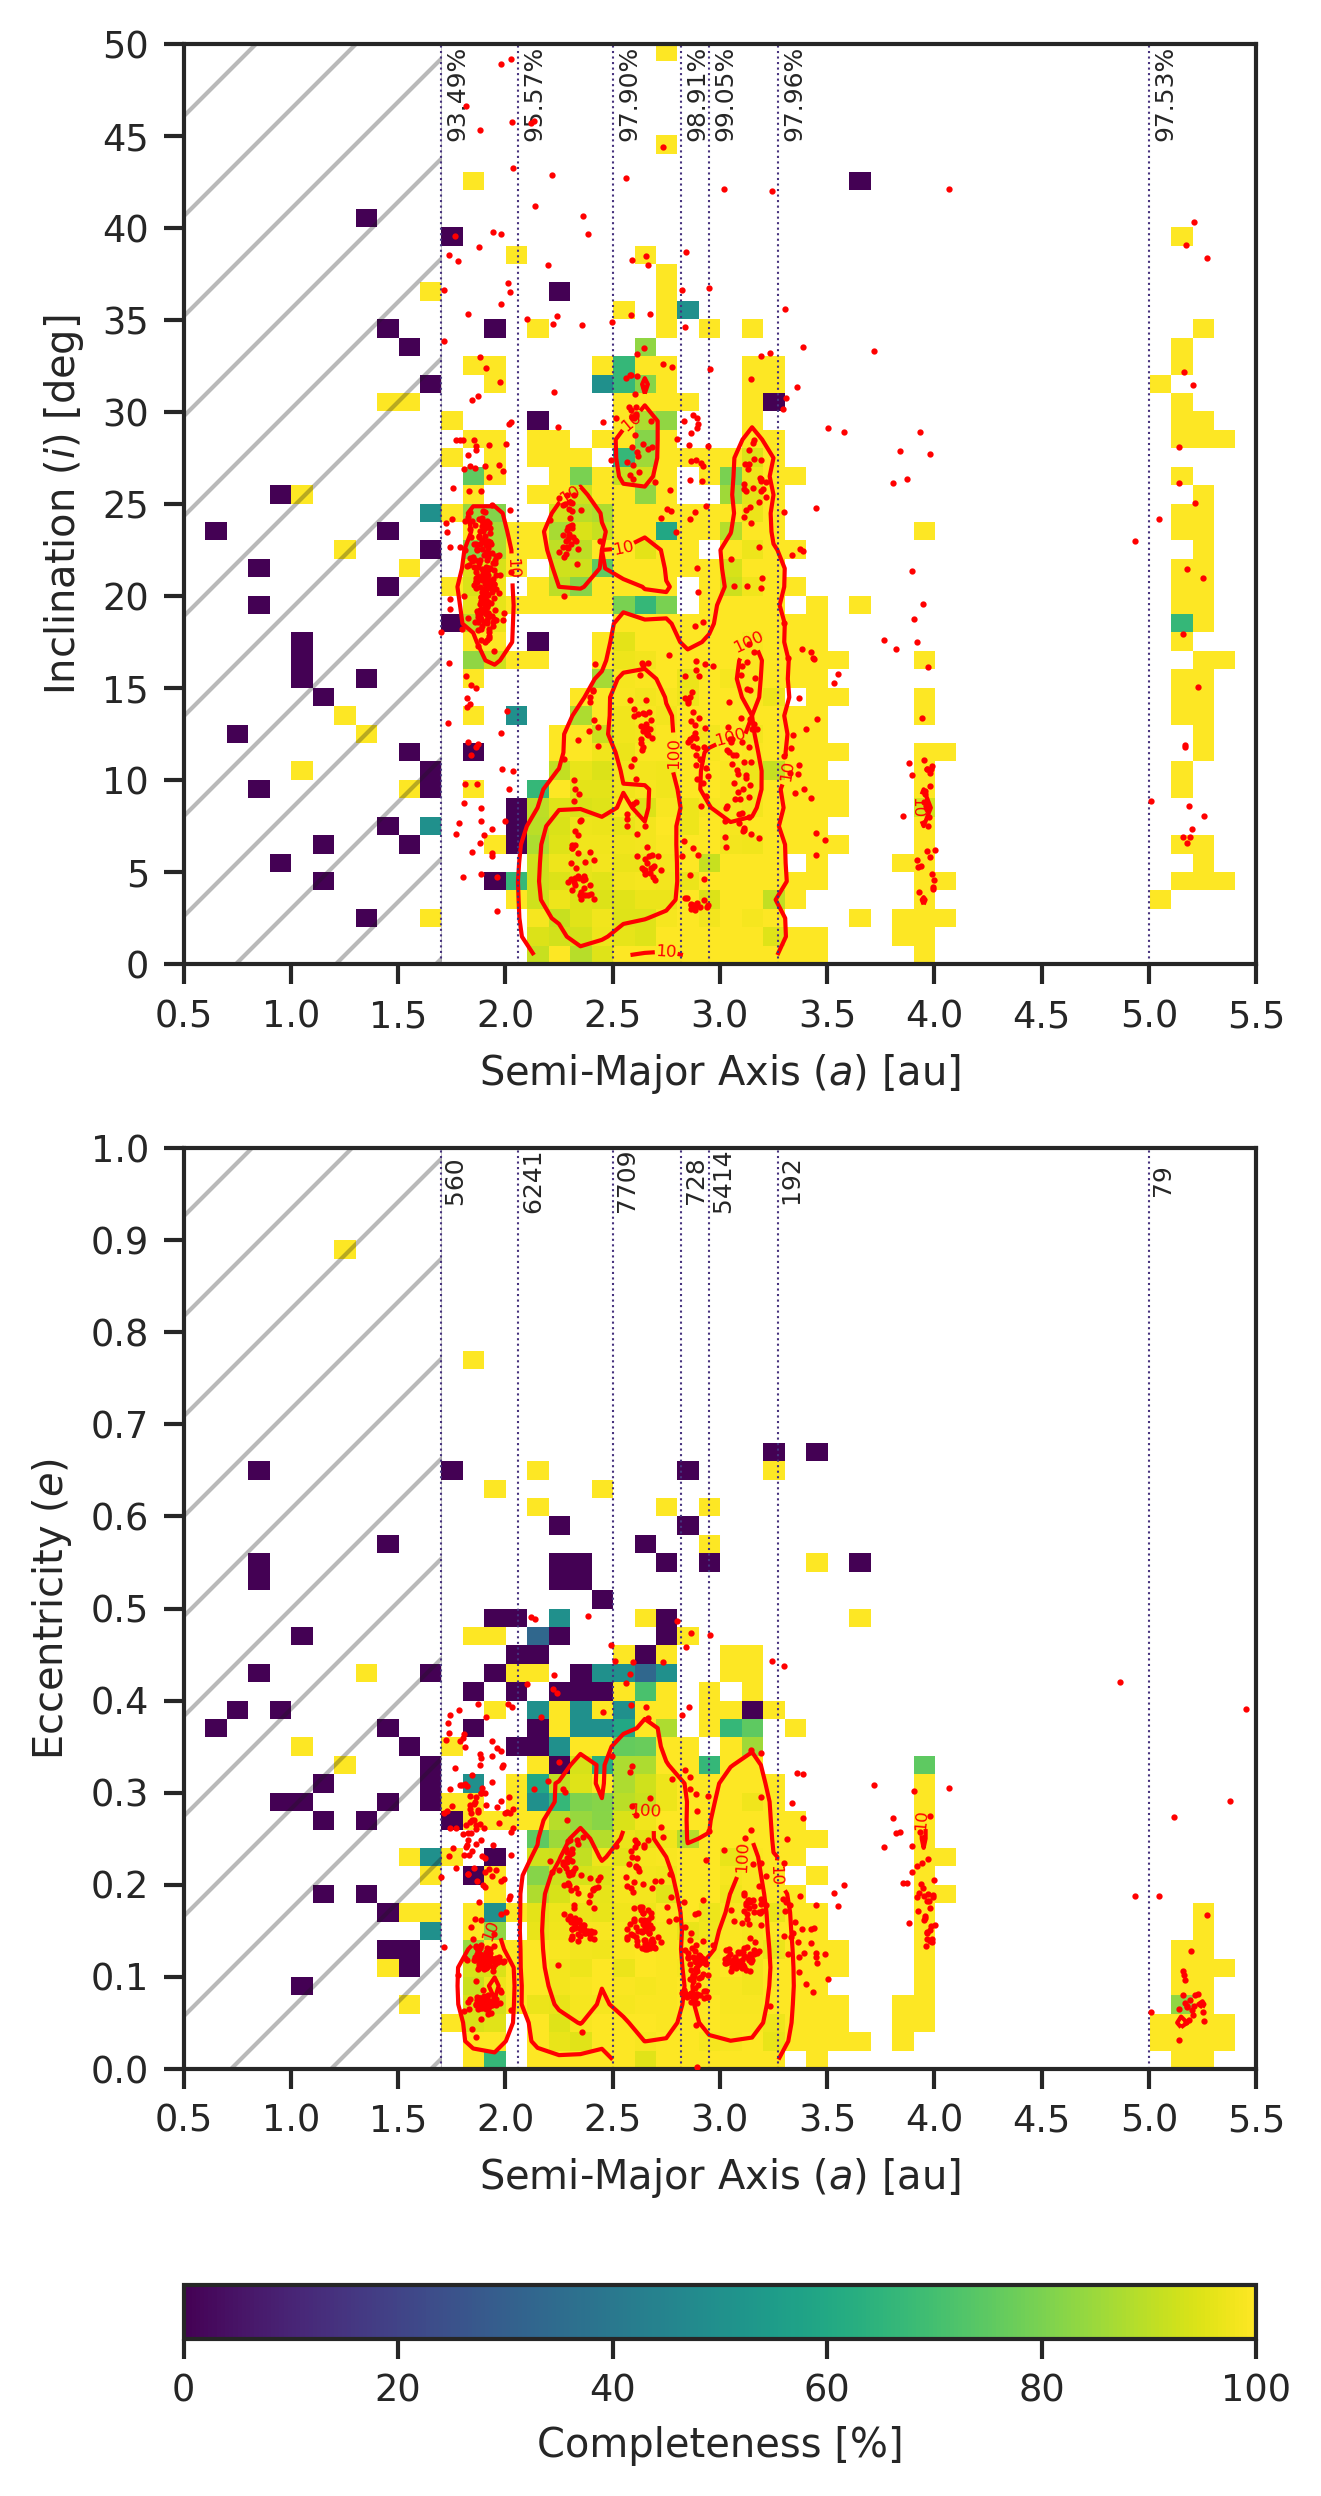

In [13]:
fig, ax = plotCompleteness(
    all_truths_recovered, 
    known_orbits, 
    test_orbits=test_orbits,
    test_orbit_scatter_kwargs={
        "s": 0.5, 
        "c": "red"
    },
)
ax[0].vlines([1.7, 2.06, 2.5, 2.82, 2.95, 3.27, 5.0], 0, 50, lw=0.5, linestyle=":")
ax[1].vlines([1.7, 2.06, 2.5, 2.82, 2.95, 3.27, 5.0], 0, 50, lw=0.5, linestyle=":")

sma_bins = [1.7, 2.06, 2.5, 2.82, 2.95, 3.27, 5.0, 50]
classes = {}
for i, (bin_start, bin_end) in enumerate(zip(sma_bins[:-1], sma_bins[1:])):
    mask = (summary_recovered["class"] == "{}<=a<{}".format(bin_start, bin_end))
    completeness_bin = summary_recovered[mask]["completeness"].values[0]
    found_bin = summary_recovered[mask]["found"].values[0]
    ax[0].text(
        bin_start + 0.02, 
        45, 
        f"{completeness_bin:.2f}%", 
        fontsize=6, 
        rotation='vertical'
    )
    
    ax[1].text(
        bin_start + 0.02, 
        0.9, 
        f"{found_bin}".rjust(8, " "), 
        fontsize=6, 
        rotation='vertical'
    )
ax[0].fill_between([0,1.7], [50,50], 
    facecolor="none", 
    hatch="/", 
    edgecolor="k", 
    linewidth=0.2,
    alpha=0.3
)
ax[1].fill_between([0,1.7], [1,1], 
    facecolor="none", 
    hatch="/", 
    edgecolor="k", 
    linewidth=0.2,
    alpha=0.3
)

if SAVE_FIGS == True:
    fig.savefig(
        os.path.join(SAVE_DIR, "ztf_a_ie_completeness.{}".format(FORMAT)),
           bbox_inches='tight'
    )

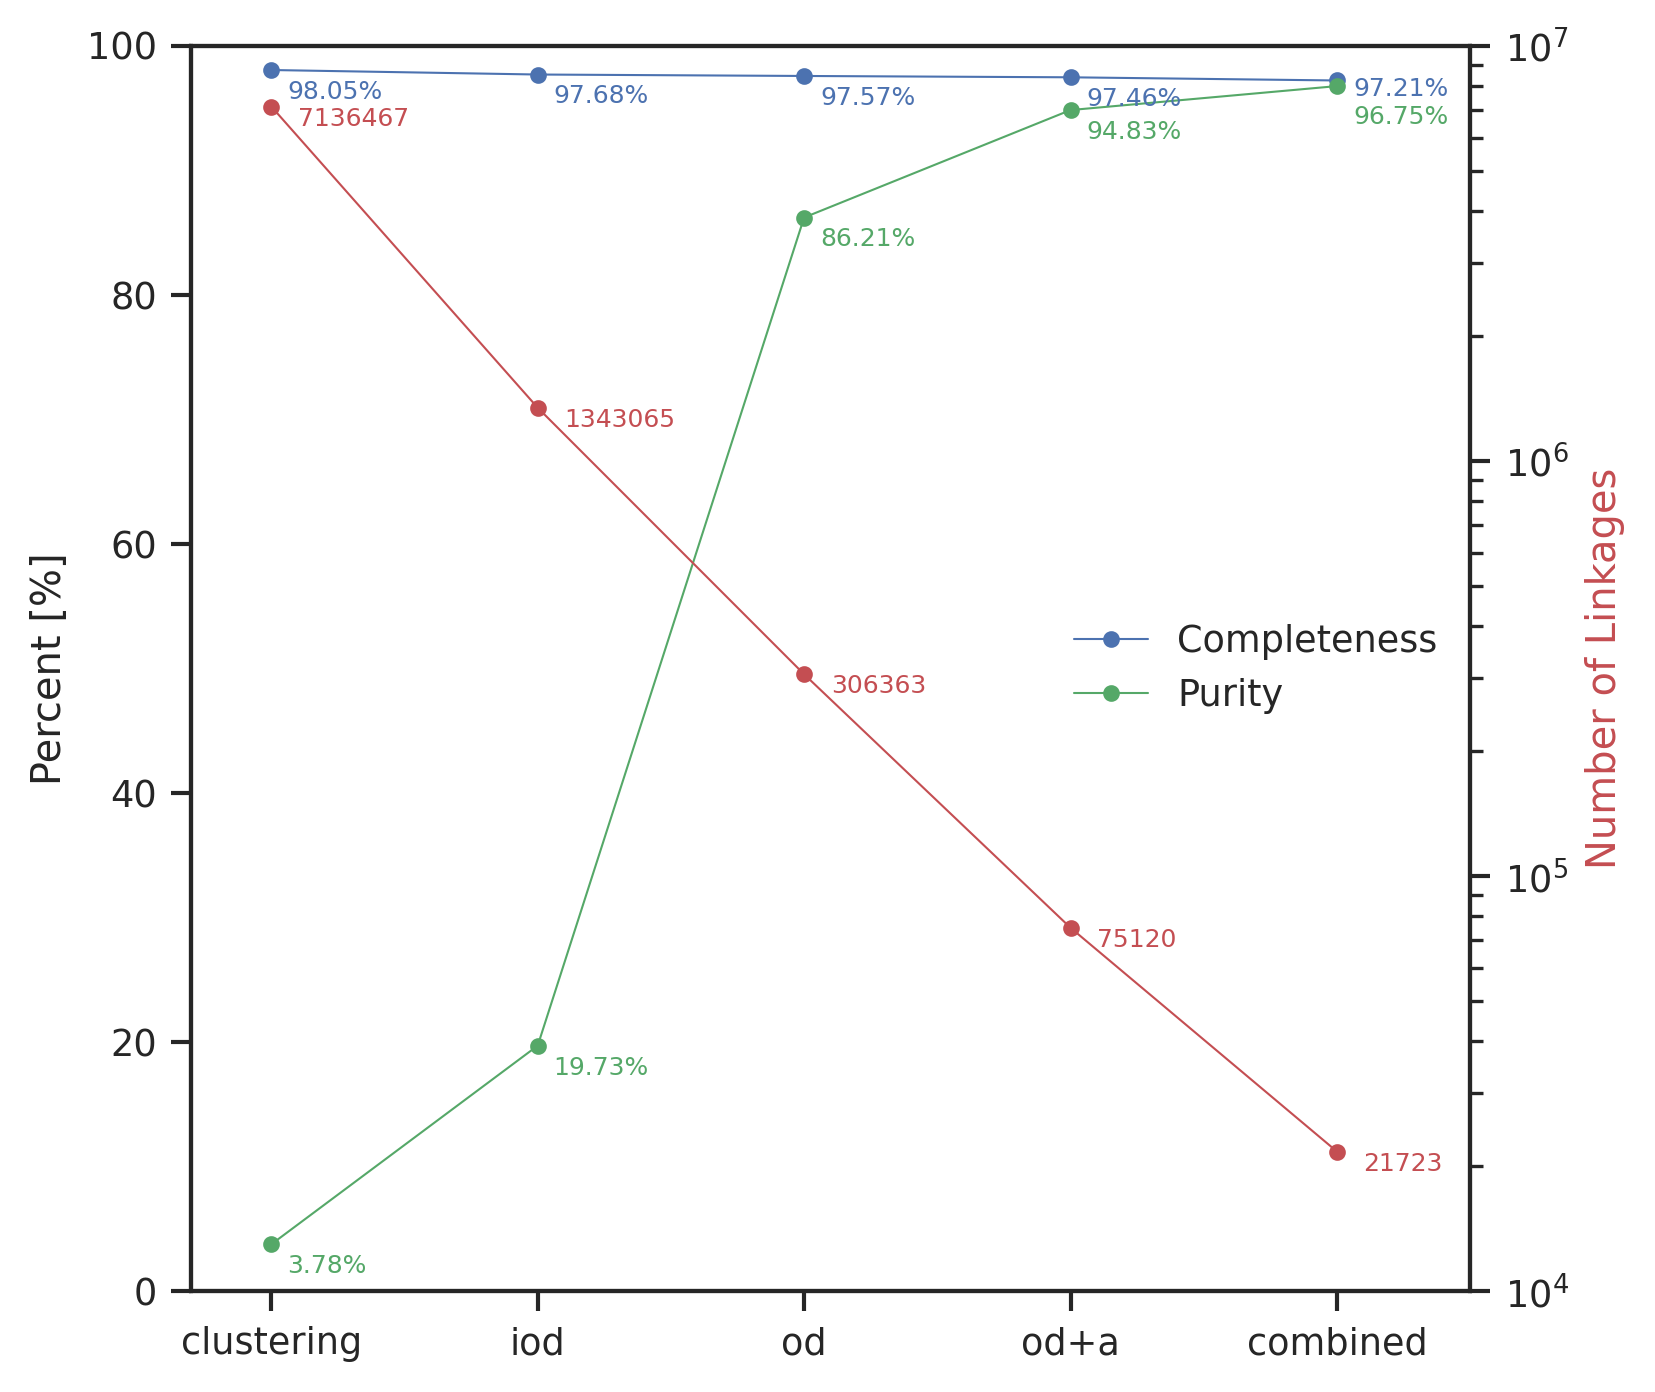

In [14]:
fig, ax = plt.subplots(1, 1, dpi=DPI, figsize=(5.5, 5.5))
components = np.arange(0, len(summary_components))
ax.plot(
    components,
    summary_components["completeness"].values, 
    label="Completeness", 
    marker="o",
    lw=0.5,
    markersize=3,
    color="b"
)
for i, v in enumerate(summary_components["completeness"].values):
    if i == 4:
        ax.text(i + 0.06, v - 1.2, f"{v:.2f}%", fontsize=6, color="b")
    else:
        ax.text(i + 0.06, v - 2.3, f"{v:.2f}%", fontsize=6, color="b")
    
ax.plot(
    components,
    summary_components["purity"].values, 
    label="Purity",
    marker="o",
    lw=0.5,
    markersize=3,
    color="g"
)
for i, v in enumerate(summary_components["purity"].values):
    if i == 4:
        ax.text(i + 0.06, v - 3, f"{v:.2f}%", fontsize=6, color="g")
    else:
        ax.text(i + 0.06, v - 2.3, f"{v:.2f}%", fontsize=6, color="g")
    
ax2 = ax.twinx()
ax2.plot(
    components,
    summary_components["num_linkages"].values, 
    label="Linkages", 
    marker="o",
    lw=0.5,
    markersize=3,
    color="r"
)
ax2.set_ylim(10**4, 10**7)
ax2.set_ylabel("Number of Linkages", color="r")
ax2.set_yscale("log")
for i, v in enumerate(summary_components["num_linkages"].values):
    ax2.text(i + 0.1, 0.90 * v, f"{v:d}", fontsize=6, color="r")
    
ax.legend(frameon=False, loc=5)
ax.set_ylabel("Percent [%]")
ax.set_xticks(components)
ax.set_xticklabels(summary_components["component"].values)
ax.set_xlim(-0.3, 4.5)
ax.set_ylim(0, 100)
if SAVE_FIGS == True:
    fig.savefig(
        os.path.join(SAVE_DIR, "ztf_component_summary_2018.{}".format(FORMAT)),
           bbox_inches='tight'
    )

### April 2021 MPCORB Analysis

In [15]:
ANALYSIS_DIR = os.path.join(RUN_DIR, "analysis_2021")

preprocessed_associations_2021 = pd.read_csv(
    os.path.join(DATA_DIR, "preprocessed_associations_20210420.csv"),
    index_col=False,
    dtype={"obs_id" : str}
)

all_orbits_recovered_2021 = pd.read_csv(
    os.path.join(ANALYSIS_DIR, "all_orbits_recovered.csv"),
    index_col=False
)
all_truths_recovered_2021 = pd.read_csv(
    os.path.join(ANALYSIS_DIR, "all_truths_recovered.csv"),
    index_col=False
)
summary_recovered_2021 = pd.read_csv(
    os.path.join(ANALYSIS_DIR, "summary_recovered.csv"),
    index_col=False
)
all_linkages_2021 = pd.read_csv(
    os.path.join(ANALYSIS_DIR, "all_linkages.csv"),
    index_col=False
)
all_truths_2021 = pd.read_csv(
    os.path.join(ANALYSIS_DIR, "all_truths.csv"),
    index_col=False
)
summary_2021 = pd.read_csv(
    os.path.join(ANALYSIS_DIR, "summary.csv"),
    index_col=False
)
summary_components_2021 = pd.read_csv(
    os.path.join(ANALYSIS_DIR, "summary_components.csv"),
    index_col=False
)

/home/moeyensj/software/anaconda3/envs/thor_py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning:

Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.



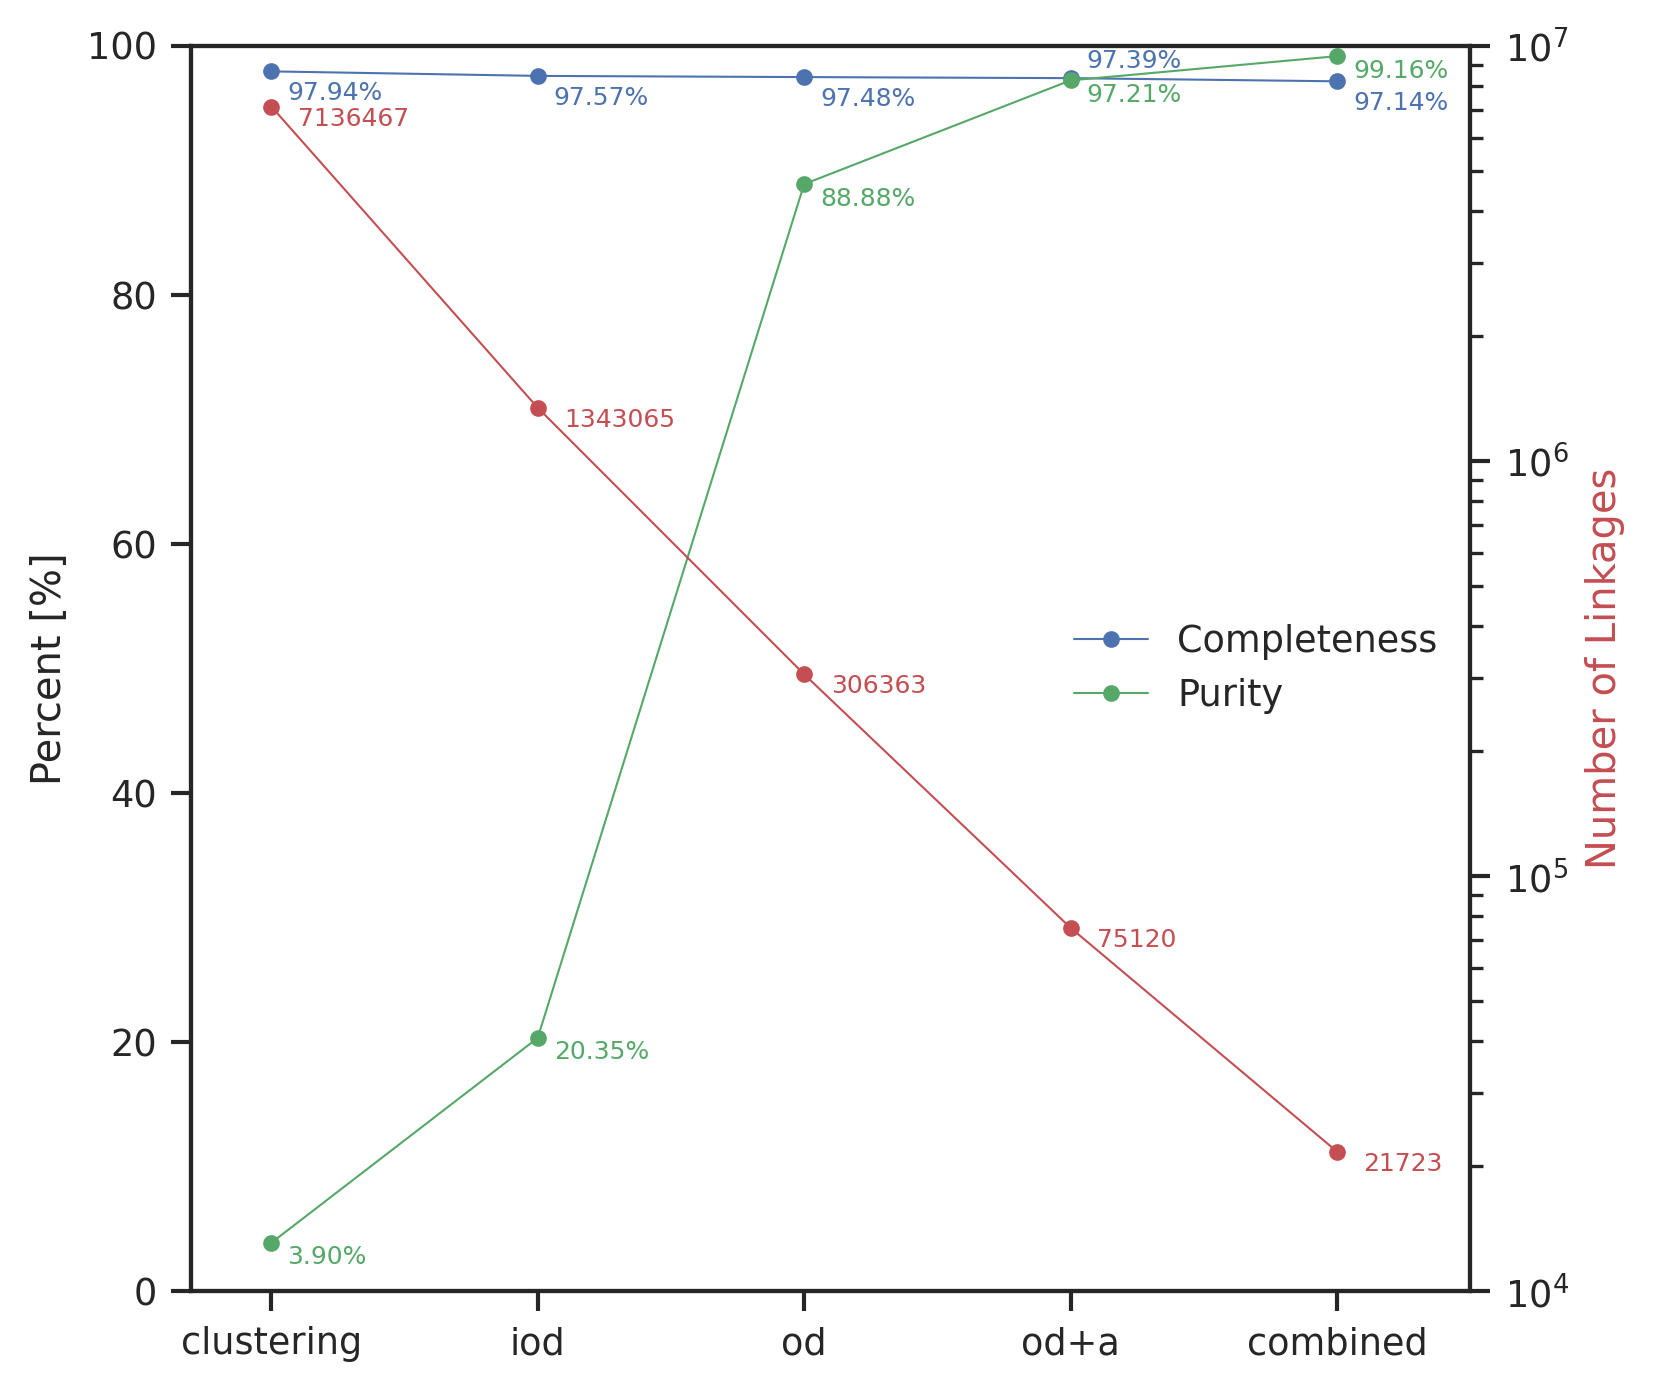

In [17]:
fig, ax = plt.subplots(1, 1, dpi=DPI, figsize=(5.5, 5.5))
components = np.arange(0, len(summary_components_2021))
ax.plot(
    components,
    summary_components_2021["completeness"].values, 
    label="Completeness", 
    marker="o",
    lw=0.5,
    markersize=3,
    color="b"
)
for i, v in enumerate(summary_components_2021["completeness"].values):
    if i == 3:
        ax.text(i + 0.06, v + 0.8, f"{v:.2f}%", fontsize=6, color="b")
    else:
        ax.text(i + 0.06, v - 2.3, f"{v:.2f}%", fontsize=6, color="b")
    
ax.plot(
    components,
    summary_components_2021["purity"].values, 
    label="Purity",
    marker="o",
    lw=0.5,
    markersize=3,
    color="g"
)
for i, v in enumerate(summary_components_2021["purity"].values):
    ax.text(i + 0.06, v - 1.7, f"{v:.2f}%", fontsize=6, color="g")
    
ax2 = ax.twinx()
ax2.plot(
    components,
    summary_components_2021["num_linkages"].values, 
    label="Linkages", 
    marker="o",
    lw=0.5,
    markersize=3,
    color="r"
)
ax2.set_ylim(10**4, 10**7)
ax2.set_ylabel("Number of Linkages", color="r")
ax2.set_yscale("log")
for i, v in enumerate(summary_components_2021["num_linkages"].values):
    ax2.text(i + 0.1, 0.90 * v, f"{v:d}", fontsize=6, color="r")
    
ax.legend(frameon=False, loc=5)
ax.set_ylabel("Percent [%]")
ax.set_xticks(components)
ax.set_xticklabels(summary_components_2021["component"].values)
ax.set_xlim(-0.3, 4.5)
ax.set_ylim(0, 100)
if SAVE_FIGS == True:
    fig.savefig(
        os.path.join(SAVE_DIR, "ztf_component_summary_2021.{}".format(FORMAT)),
           bbox_inches='tight'
    )

In [18]:
from thor.orbits import generateEphemeris

def plotLinkage(preprocessed_observations, linkages, linkage_members, linkage_id, ax=None, recenter=False):
    
    if "cluster_id" in linkage_members.columns:
        linkage_id_col = "cluster_id"
    elif "orbit_id" in linkage_members.columns:
        linkage_id_col = "orbit_id"
    else:
        raise ValueError("")
        
    
    members = linkage_members[linkage_members[linkage_id_col].isin([linkage_id])]
    obs_ids = members["obs_id"].values
    linkage_observations = preprocessed_observations[preprocessed_observations["obs_id"].isin(obs_ids)]
    
    observers = {}
    for code in linkage_observations["observatory_code"].unique():
        times = Time(
            linkage_observations[linkage_observations["observatory_code"].isin([code])]["mjd_utc"].values,
            format="mjd",
            scale="utc"
        )
        
        observers[code] = Time(
            np.linspace(times.utc.mjd.min()-0.5, times.utc.mjd.max()+0.5, 30),
            format="mjd",
            scale="utc"
        )
            
    orbit = Orbits.from_df(linkages[linkages[linkage_id_col].isin([linkage_id])])   
    
    ephemeris = generateEphemeris(
        orbit,
        observers,
        backend="PYOORB",
        threads=1
    )
    eph_ra = ephemeris["RA_deg"].values
    obs_ra = linkage_observations["RA_deg"].values
    
    if recenter:
        eph_ra = np.where(eph_ra > 180, eph_ra - 360.0, eph_ra)
        obs_ra = np.where(obs_ra > 180, obs_ra - 360.0, obs_ra)

    if ax == None:
        fig, ax = plt.subplots(1, 1, dpi=200)
        
    ax.scatter(
        obs_ra,
        linkage_observations["Dec_deg"].values,    
        s=15,
        c='r',
        marker="+",
        zorder=10
    )
    ax.plot(
        eph_ra,
        ephemeris["Dec_deg"].values,
        lw=1,
    )
    #ax.set_xlabel(r"$\alpha$ [$\deg$]")
    #ax.set_ylabel(r"$\delta$ [$\deg$]")
    if recenter:
        #ax.set_ylim(-30, 90)
        ax.set_xlim(-2, 4)
        ticks = ax.get_xticks()
        ticks[ticks < 0] += 360
        ax.set_xticklabels([int(tick) for tick in ticks])
        #ax.set_yticks([-30, 0, 30, 60, 90])
    ax.legend(frameon=False)
    

    return linkage_observations

In [19]:
from thor.orbits import convertOrbitalElements

In [20]:
unknown_2021_high_quality_orbit_ids = pd.read_csv(
    "/mnt/data/projects/thor/thor_results/ztf/v1.1/run4/"
)

unknown_2021_high_quality_orbits = Orbits.from_df(unknown_2021_high_quality)

kepler = convertOrbitalElements(
    unknown_2021_high_quality_orbits.cartesian,
    "cartesian",
    "keplerian"
)

NameError: name 'unknown_2021_high_quality' is not defined

In [ ]:
kepler

In [ ]:

#orbit_id = np.random.choice(found_since_2018_high_quality["orbit_id"].unique(), 1)[0]
orbit_ids = unknown_2021_high_quality["orbit_id"].unique()


fig, ax = plt.subplots(6, 2, dpi=300, figsize=(5.5,11.5))
fig.subplots_adjust(
    # the left side of the subplots of the figure
    left=0.15,  
    # the right side of the subplots of the figure
    right=1.0,
    # the bottom of the subplots of the figure
    bottom=0.2,
    # the top of the subplots of the figure
    top=0.95,
    # the amount of width reserved for space between subplots,
    # expressed as a fraction of the average axis width
    wspace=0.05,   
    # the amount of height reserved for space between subplots,
    # expressed as a fraction of the average axis height
    hspace=0.2
)

id_iter = 0
for i in range(6):
    for j in range(2):
        if id_iter == 8:
            recenter = True
        else:
            recenter = False
        linkage_observations = plotLinkage(
            preprocessed_observations, 
            recovered_orbits, 
            recovered_orbit_members, 
            orbit_ids[id_iter],
            recenter=recenter,
            ax=ax[i, j]
        )
        id_iter += 1
        if id_iter == 11:
            break

xlim = (11.3, 12.1)   
ylim = (-14.0, -12.0)
ax[0,0].set_xticks(np.arange(xlim[0], xlim[1] + 0.2, 0.2))
ax[0,0].set_ylim(*ylim)
ax[0,0].set_xlim(*xlim)
string = f"a: {kepler[0, 0]:1.3f} [au]\ne : {kepler[0, 1]:1.3f}\ni : {kepler[0, 2]:1.3f} [deg]" 
ax[0,0].text(xlim[0] + 0.05, ylim[1], string, fontsize=7)

for i in range(6):
    ax[i, 1].yaxis.set_label_position("right")
    ax[i, 1].yaxis.tick_right()


In [ ]:
analysis_orbit_members_2021[analysis_orbit_members_2021["orbit_id"] == orbit_id]

In [ ]:
recovered_orbits[recovered_orbits["orbit_id"] == orbit_id]